In [26]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import auc,roc_curve

from sklearn.externals import joblib
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

nrow = 50000
number_of_time = 10

In [2]:
train = pd.read_csv('../data/train.csv',nrows=nrow)
train.drop('ID_code',inplace= True,axis=1)

In [3]:
y = train['target']
x = train.drop('target',axis=1)

In [9]:
'''
model = Pipeline([
    ('scaler',MinMaxScaler()),
    ('model',LogisticRegression(C=0.01,class_weight = 'balanced',solver='lbfgs'))
]).fit(x,y)

joblib.dump(model,'../model/lr_pipe.m')
'''

"\nmodel = Pipeline([\n    ('scaler',MinMaxScaler()),\n    ('model',LogisticRegression(C=0.01,class_weight = 'balanced',solver='lbfgs'))\n]).fit(x,y)\n\njoblib.dump(model,'../model/lr_pipe.m')\n"

In [104]:
#test = pd.read_csv('../data/test.csv')
#sub = pd.DataFrame()
#sub['ID_code'] = test['ID_code']
#test.drop('ID_code',axis=1,inplace=True)
train,test = train_test_split(train,test_size = 0.3)

In [105]:
train_x = train.drop('target',axis=1).reset_index(drop=True)
train_y = pd.DataFrame(train['target']).reset_index(drop=True)

#for i in range(number_of_time):
#    models = k_fold_train(train_x,train_y)

In [106]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.05,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial'
}
def k_fold_train(x,y):
    kf = StratifiedKFold(n_splits=3)
    
    for train_index,val_index in kf.split(x,y):
        train_model_x,val_model_x = x.iloc[train_index,:],x.iloc[val_index,:]
        train_model_y,val_model_y = y.iloc[train_index],y.iloc[val_index]
        
        train_data = lgb.Dataset(train_model_x,train_model_y)
        val_data = lgb.Dataset(val_model_x,val_model_y)
        
        model = lgb.train(param,train_set=train_data,num_boost_round=10000,early_stopping_rounds=3000,valid_sets = val_data)
        return(model)

In [107]:
m = k_fold_train(train_x,train_y)

[1]	valid_0's auc: 0.580108
Training until validation scores don't improve for 3000 rounds.
[2]	valid_0's auc: 0.602676
[3]	valid_0's auc: 0.62621
[4]	valid_0's auc: 0.635035
[5]	valid_0's auc: 0.641501
[6]	valid_0's auc: 0.648483
[7]	valid_0's auc: 0.65347
[8]	valid_0's auc: 0.659884
[9]	valid_0's auc: 0.674161
[10]	valid_0's auc: 0.684219
[11]	valid_0's auc: 0.686084
[12]	valid_0's auc: 0.69898
[13]	valid_0's auc: 0.705955
[14]	valid_0's auc: 0.718875
[15]	valid_0's auc: 0.71805
[16]	valid_0's auc: 0.720936
[17]	valid_0's auc: 0.72186
[18]	valid_0's auc: 0.7324
[19]	valid_0's auc: 0.735517
[20]	valid_0's auc: 0.740102
[21]	valid_0's auc: 0.743089
[22]	valid_0's auc: 0.743804
[23]	valid_0's auc: 0.741653
[24]	valid_0's auc: 0.746
[25]	valid_0's auc: 0.746217
[26]	valid_0's auc: 0.750981
[27]	valid_0's auc: 0.754998
[28]	valid_0's auc: 0.75276
[29]	valid_0's auc: 0.752833
[30]	valid_0's auc: 0.754885
[31]	valid_0's auc: 0.753721
[32]	valid_0's auc: 0.753975
[33]	valid_0's auc: 0.754265

[283]	valid_0's auc: 0.864043
[284]	valid_0's auc: 0.86401
[285]	valid_0's auc: 0.86407
[286]	valid_0's auc: 0.864136
[287]	valid_0's auc: 0.864071
[288]	valid_0's auc: 0.864097
[289]	valid_0's auc: 0.863912
[290]	valid_0's auc: 0.864123
[291]	valid_0's auc: 0.864193
[292]	valid_0's auc: 0.864287
[293]	valid_0's auc: 0.864702
[294]	valid_0's auc: 0.864551
[295]	valid_0's auc: 0.864383
[296]	valid_0's auc: 0.864284
[297]	valid_0's auc: 0.864185
[298]	valid_0's auc: 0.864358
[299]	valid_0's auc: 0.864124
[300]	valid_0's auc: 0.864453
[301]	valid_0's auc: 0.864669
[302]	valid_0's auc: 0.865421
[303]	valid_0's auc: 0.865399
[304]	valid_0's auc: 0.865706
[305]	valid_0's auc: 0.865698
[306]	valid_0's auc: 0.865838
[307]	valid_0's auc: 0.865854
[308]	valid_0's auc: 0.866081
[309]	valid_0's auc: 0.866198
[310]	valid_0's auc: 0.866024
[311]	valid_0's auc: 0.86587
[312]	valid_0's auc: 0.866277
[313]	valid_0's auc: 0.866133
[314]	valid_0's auc: 0.866224
[315]	valid_0's auc: 0.866152
[316]	valid_0

[653]	valid_0's auc: 0.874575
[654]	valid_0's auc: 0.874609
[655]	valid_0's auc: 0.874626
[656]	valid_0's auc: 0.874624
[657]	valid_0's auc: 0.874626
[658]	valid_0's auc: 0.874601
[659]	valid_0's auc: 0.874724
[660]	valid_0's auc: 0.874852
[661]	valid_0's auc: 0.874681
[662]	valid_0's auc: 0.874571
[663]	valid_0's auc: 0.874817
[664]	valid_0's auc: 0.874644
[665]	valid_0's auc: 0.874691
[666]	valid_0's auc: 0.874766
[667]	valid_0's auc: 0.874903
[668]	valid_0's auc: 0.87484
[669]	valid_0's auc: 0.874955
[670]	valid_0's auc: 0.874913
[671]	valid_0's auc: 0.874964
[672]	valid_0's auc: 0.874898
[673]	valid_0's auc: 0.874862
[674]	valid_0's auc: 0.874659
[675]	valid_0's auc: 0.874699
[676]	valid_0's auc: 0.874532
[677]	valid_0's auc: 0.874735
[678]	valid_0's auc: 0.874727
[679]	valid_0's auc: 0.874669
[680]	valid_0's auc: 0.874558
[681]	valid_0's auc: 0.874682
[682]	valid_0's auc: 0.874611
[683]	valid_0's auc: 0.874756
[684]	valid_0's auc: 0.874713
[685]	valid_0's auc: 0.874895
[686]	valid

[979]	valid_0's auc: 0.875177
[980]	valid_0's auc: 0.875224
[981]	valid_0's auc: 0.875359
[982]	valid_0's auc: 0.875367
[983]	valid_0's auc: 0.875409
[984]	valid_0's auc: 0.875378
[985]	valid_0's auc: 0.87532
[986]	valid_0's auc: 0.875367
[987]	valid_0's auc: 0.875376
[988]	valid_0's auc: 0.875384
[989]	valid_0's auc: 0.875336
[990]	valid_0's auc: 0.875369
[991]	valid_0's auc: 0.875329
[992]	valid_0's auc: 0.875096
[993]	valid_0's auc: 0.875087
[994]	valid_0's auc: 0.875026
[995]	valid_0's auc: 0.874875
[996]	valid_0's auc: 0.87481
[997]	valid_0's auc: 0.874788
[998]	valid_0's auc: 0.874691
[999]	valid_0's auc: 0.874684
[1000]	valid_0's auc: 0.874674
[1001]	valid_0's auc: 0.874662
[1002]	valid_0's auc: 0.874763
[1003]	valid_0's auc: 0.874682
[1004]	valid_0's auc: 0.874653
[1005]	valid_0's auc: 0.874665
[1006]	valid_0's auc: 0.874539
[1007]	valid_0's auc: 0.874525
[1008]	valid_0's auc: 0.874588
[1009]	valid_0's auc: 0.874645
[1010]	valid_0's auc: 0.874625
[1011]	valid_0's auc: 0.874625


[1359]	valid_0's auc: 0.874624
[1360]	valid_0's auc: 0.874561
[1361]	valid_0's auc: 0.874496
[1362]	valid_0's auc: 0.874442
[1363]	valid_0's auc: 0.874499
[1364]	valid_0's auc: 0.874382
[1365]	valid_0's auc: 0.874309
[1366]	valid_0's auc: 0.874399
[1367]	valid_0's auc: 0.874269
[1368]	valid_0's auc: 0.87425
[1369]	valid_0's auc: 0.874149
[1370]	valid_0's auc: 0.874171
[1371]	valid_0's auc: 0.874106
[1372]	valid_0's auc: 0.874035
[1373]	valid_0's auc: 0.874059
[1374]	valid_0's auc: 0.874102
[1375]	valid_0's auc: 0.874055
[1376]	valid_0's auc: 0.873992
[1377]	valid_0's auc: 0.874161
[1378]	valid_0's auc: 0.874102
[1379]	valid_0's auc: 0.874078
[1380]	valid_0's auc: 0.874087
[1381]	valid_0's auc: 0.874045
[1382]	valid_0's auc: 0.874012
[1383]	valid_0's auc: 0.873895
[1384]	valid_0's auc: 0.873836
[1385]	valid_0's auc: 0.873802
[1386]	valid_0's auc: 0.873727
[1387]	valid_0's auc: 0.873677
[1388]	valid_0's auc: 0.873738
[1389]	valid_0's auc: 0.873815
[1390]	valid_0's auc: 0.873815
[1391]	va

[1662]	valid_0's auc: 0.87177
[1663]	valid_0's auc: 0.871783
[1664]	valid_0's auc: 0.871759
[1665]	valid_0's auc: 0.871739
[1666]	valid_0's auc: 0.871797
[1667]	valid_0's auc: 0.871791
[1668]	valid_0's auc: 0.871844
[1669]	valid_0's auc: 0.871846
[1670]	valid_0's auc: 0.871819
[1671]	valid_0's auc: 0.871903
[1672]	valid_0's auc: 0.871937
[1673]	valid_0's auc: 0.872009
[1674]	valid_0's auc: 0.871938
[1675]	valid_0's auc: 0.87185
[1676]	valid_0's auc: 0.871761
[1677]	valid_0's auc: 0.871814
[1678]	valid_0's auc: 0.871809
[1679]	valid_0's auc: 0.871775
[1680]	valid_0's auc: 0.871798
[1681]	valid_0's auc: 0.871832
[1682]	valid_0's auc: 0.871737
[1683]	valid_0's auc: 0.871712
[1684]	valid_0's auc: 0.871772
[1685]	valid_0's auc: 0.871801
[1686]	valid_0's auc: 0.871971
[1687]	valid_0's auc: 0.872005
[1688]	valid_0's auc: 0.87198
[1689]	valid_0's auc: 0.871971
[1690]	valid_0's auc: 0.872052
[1691]	valid_0's auc: 0.871927
[1692]	valid_0's auc: 0.871864
[1693]	valid_0's auc: 0.871906
[1694]	vali

[1948]	valid_0's auc: 0.870062
[1949]	valid_0's auc: 0.870056
[1950]	valid_0's auc: 0.870041
[1951]	valid_0's auc: 0.870074
[1952]	valid_0's auc: 0.870075
[1953]	valid_0's auc: 0.870099
[1954]	valid_0's auc: 0.86998
[1955]	valid_0's auc: 0.869955
[1956]	valid_0's auc: 0.869966
[1957]	valid_0's auc: 0.870009
[1958]	valid_0's auc: 0.869972
[1959]	valid_0's auc: 0.870032
[1960]	valid_0's auc: 0.870046
[1961]	valid_0's auc: 0.870149
[1962]	valid_0's auc: 0.870152
[1963]	valid_0's auc: 0.870152
[1964]	valid_0's auc: 0.870248
[1965]	valid_0's auc: 0.870193
[1966]	valid_0's auc: 0.870199
[1967]	valid_0's auc: 0.870247
[1968]	valid_0's auc: 0.870289
[1969]	valid_0's auc: 0.87029
[1970]	valid_0's auc: 0.87028
[1971]	valid_0's auc: 0.87031
[1972]	valid_0's auc: 0.870361
[1973]	valid_0's auc: 0.870353
[1974]	valid_0's auc: 0.870338
[1975]	valid_0's auc: 0.870319
[1976]	valid_0's auc: 0.870347
[1977]	valid_0's auc: 0.870406
[1978]	valid_0's auc: 0.870385
[1979]	valid_0's auc: 0.870419
[1980]	valid

[2249]	valid_0's auc: 0.87049
[2250]	valid_0's auc: 0.870476
[2251]	valid_0's auc: 0.870498
[2252]	valid_0's auc: 0.870452
[2253]	valid_0's auc: 0.870446
[2254]	valid_0's auc: 0.870437
[2255]	valid_0's auc: 0.870479
[2256]	valid_0's auc: 0.870416
[2257]	valid_0's auc: 0.870466
[2258]	valid_0's auc: 0.870471
[2259]	valid_0's auc: 0.870569
[2260]	valid_0's auc: 0.870551
[2261]	valid_0's auc: 0.870594
[2262]	valid_0's auc: 0.870595
[2263]	valid_0's auc: 0.870564
[2264]	valid_0's auc: 0.870597
[2265]	valid_0's auc: 0.870583
[2266]	valid_0's auc: 0.870511
[2267]	valid_0's auc: 0.87046
[2268]	valid_0's auc: 0.870571
[2269]	valid_0's auc: 0.870533
[2270]	valid_0's auc: 0.870439
[2271]	valid_0's auc: 0.87045
[2272]	valid_0's auc: 0.870481
[2273]	valid_0's auc: 0.870501
[2274]	valid_0's auc: 0.870512
[2275]	valid_0's auc: 0.870605
[2276]	valid_0's auc: 0.870631
[2277]	valid_0's auc: 0.870602
[2278]	valid_0's auc: 0.870653
[2279]	valid_0's auc: 0.870571
[2280]	valid_0's auc: 0.870524
[2281]	vali

[2549]	valid_0's auc: 0.870672
[2550]	valid_0's auc: 0.870744
[2551]	valid_0's auc: 0.870659
[2552]	valid_0's auc: 0.870598
[2553]	valid_0's auc: 0.870605
[2554]	valid_0's auc: 0.870537
[2555]	valid_0's auc: 0.870583
[2556]	valid_0's auc: 0.870572
[2557]	valid_0's auc: 0.870533
[2558]	valid_0's auc: 0.870565
[2559]	valid_0's auc: 0.870517
[2560]	valid_0's auc: 0.87046
[2561]	valid_0's auc: 0.870411
[2562]	valid_0's auc: 0.870491
[2563]	valid_0's auc: 0.870451
[2564]	valid_0's auc: 0.870418
[2565]	valid_0's auc: 0.870425
[2566]	valid_0's auc: 0.87044
[2567]	valid_0's auc: 0.870416
[2568]	valid_0's auc: 0.870434
[2569]	valid_0's auc: 0.870418
[2570]	valid_0's auc: 0.870451
[2571]	valid_0's auc: 0.870421
[2572]	valid_0's auc: 0.870456
[2573]	valid_0's auc: 0.870533
[2574]	valid_0's auc: 0.870505
[2575]	valid_0's auc: 0.870537
[2576]	valid_0's auc: 0.870568
[2577]	valid_0's auc: 0.870561
[2578]	valid_0's auc: 0.8705
[2579]	valid_0's auc: 0.870534
[2580]	valid_0's auc: 0.870592
[2581]	valid

[2838]	valid_0's auc: 0.869929
[2839]	valid_0's auc: 0.869936
[2840]	valid_0's auc: 0.869907
[2841]	valid_0's auc: 0.869835
[2842]	valid_0's auc: 0.869801
[2843]	valid_0's auc: 0.869788
[2844]	valid_0's auc: 0.869782
[2845]	valid_0's auc: 0.869783
[2846]	valid_0's auc: 0.869791
[2847]	valid_0's auc: 0.86982
[2848]	valid_0's auc: 0.869847
[2849]	valid_0's auc: 0.869861
[2850]	valid_0's auc: 0.869869
[2851]	valid_0's auc: 0.869922
[2852]	valid_0's auc: 0.869933
[2853]	valid_0's auc: 0.869983
[2854]	valid_0's auc: 0.870006
[2855]	valid_0's auc: 0.870013
[2856]	valid_0's auc: 0.870018
[2857]	valid_0's auc: 0.870008
[2858]	valid_0's auc: 0.870034
[2859]	valid_0's auc: 0.869999
[2860]	valid_0's auc: 0.869975
[2861]	valid_0's auc: 0.869967
[2862]	valid_0's auc: 0.870008
[2863]	valid_0's auc: 0.869993
[2864]	valid_0's auc: 0.87002
[2865]	valid_0's auc: 0.869985
[2866]	valid_0's auc: 0.870009
[2867]	valid_0's auc: 0.870019
[2868]	valid_0's auc: 0.870011
[2869]	valid_0's auc: 0.869961
[2870]	val

[3172]	valid_0's auc: 0.869109
[3173]	valid_0's auc: 0.869086
[3174]	valid_0's auc: 0.869052
[3175]	valid_0's auc: 0.869036
[3176]	valid_0's auc: 0.869092
[3177]	valid_0's auc: 0.869109
[3178]	valid_0's auc: 0.869111
[3179]	valid_0's auc: 0.86915
[3180]	valid_0's auc: 0.869201
[3181]	valid_0's auc: 0.869192
[3182]	valid_0's auc: 0.869234
[3183]	valid_0's auc: 0.869221
[3184]	valid_0's auc: 0.869225
[3185]	valid_0's auc: 0.869247
[3186]	valid_0's auc: 0.869216
[3187]	valid_0's auc: 0.869275
[3188]	valid_0's auc: 0.869285
[3189]	valid_0's auc: 0.869313
[3190]	valid_0's auc: 0.869315
[3191]	valid_0's auc: 0.869259
[3192]	valid_0's auc: 0.869279
[3193]	valid_0's auc: 0.869269
[3194]	valid_0's auc: 0.869323
[3195]	valid_0's auc: 0.86927
[3196]	valid_0's auc: 0.869234
[3197]	valid_0's auc: 0.869278
[3198]	valid_0's auc: 0.869309
[3199]	valid_0's auc: 0.869329
[3200]	valid_0's auc: 0.869359
[3201]	valid_0's auc: 0.86937
[3202]	valid_0's auc: 0.869315
[3203]	valid_0's auc: 0.869322
[3204]	vali

[3459]	valid_0's auc: 0.868994
[3460]	valid_0's auc: 0.869019
[3461]	valid_0's auc: 0.86903
[3462]	valid_0's auc: 0.869037
[3463]	valid_0's auc: 0.869032
[3464]	valid_0's auc: 0.868996
[3465]	valid_0's auc: 0.868963
[3466]	valid_0's auc: 0.868943
[3467]	valid_0's auc: 0.868938
[3468]	valid_0's auc: 0.868993
[3469]	valid_0's auc: 0.868924
[3470]	valid_0's auc: 0.868919
[3471]	valid_0's auc: 0.86894
[3472]	valid_0's auc: 0.868939
[3473]	valid_0's auc: 0.868948
[3474]	valid_0's auc: 0.868979
[3475]	valid_0's auc: 0.86896
[3476]	valid_0's auc: 0.86894
[3477]	valid_0's auc: 0.868978
[3478]	valid_0's auc: 0.868956
[3479]	valid_0's auc: 0.868989
[3480]	valid_0's auc: 0.868999
[3481]	valid_0's auc: 0.86903
[3482]	valid_0's auc: 0.869016
[3483]	valid_0's auc: 0.869004
[3484]	valid_0's auc: 0.869004
[3485]	valid_0's auc: 0.868995
[3486]	valid_0's auc: 0.868976
[3487]	valid_0's auc: 0.869008
[3488]	valid_0's auc: 0.869008
[3489]	valid_0's auc: 0.869047
[3490]	valid_0's auc: 0.868989
[3491]	valid_

[3746]	valid_0's auc: 0.868656
[3747]	valid_0's auc: 0.868704
[3748]	valid_0's auc: 0.868688
[3749]	valid_0's auc: 0.868718
[3750]	valid_0's auc: 0.868714
[3751]	valid_0's auc: 0.868689
[3752]	valid_0's auc: 0.868694
[3753]	valid_0's auc: 0.86866
[3754]	valid_0's auc: 0.868673
[3755]	valid_0's auc: 0.868657
[3756]	valid_0's auc: 0.868618
[3757]	valid_0's auc: 0.86864
[3758]	valid_0's auc: 0.868613
[3759]	valid_0's auc: 0.868597
[3760]	valid_0's auc: 0.868588
[3761]	valid_0's auc: 0.868627
[3762]	valid_0's auc: 0.868613
[3763]	valid_0's auc: 0.868606
[3764]	valid_0's auc: 0.868591
[3765]	valid_0's auc: 0.868586
[3766]	valid_0's auc: 0.868554
[3767]	valid_0's auc: 0.868569
[3768]	valid_0's auc: 0.868547
[3769]	valid_0's auc: 0.868505
[3770]	valid_0's auc: 0.868529
[3771]	valid_0's auc: 0.868535
[3772]	valid_0's auc: 0.868493
[3773]	valid_0's auc: 0.868492
[3774]	valid_0's auc: 0.86845
[3775]	valid_0's auc: 0.86841
[3776]	valid_0's auc: 0.868394
[3777]	valid_0's auc: 0.868402
[3778]	valid

In [108]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [109]:
base_line = LogisticRegression(C=0.01,class_weight = 'balanced',solver='lbfgs',max_iter=5000).\
    fit(train_x,train_y['target']).predict_proba(test.drop('target',axis=1))[:,1]
result_df = pd.DataFrame()
result_df['label'] = test['target']
result_df['base'] = base_line

In [110]:
pred = m.predict(test.drop('target',axis=1))

In [111]:
result_df['lgb'] = pred
result_df['comb'] = (pred + base_line)/2

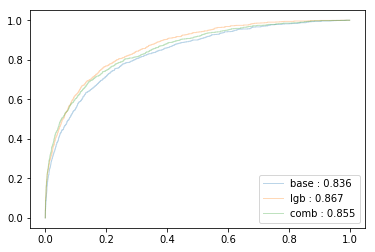

,models,auc_score
0,base,0.836421
1,lgb,0.866573
2,comb,0.854548


In [112]:
plotGraph(result_df)

In [100]:
pred = m.predict(test)

In [101]:
sub['target'] = pred
sub.to_csv("../data/one_round_sub.csv",index=False)